In [1]:
import os
import itertools
import pickle

import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import cross_val_score

from sklearn.metrics import f1_score, make_scorer, classification_report

from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

## Project Planning

Let's outline the main steps of the project:
- Understanding the nature of the data .info() .describe()
- Exploratory analysis - histograms, boxplots and value counts
- Deal with missing data
- Check metrics correlation
- Themes to look into:
  - Level of wealth as a predictor
  - Location of cabin as a predictor
  - Age
  - Title
- Feature engineering
- Data preprocessing and scaling
- Baseline models
- Trained models
- Comparison.

<div align="center">
  <h3>Data Dictionary</h3>
</div>

| Variable  | Definition                | Key                                       |
|-----------|---------------------------|-------------------------------------------|
| survival  | Survival                  | 0 = No, 1 = Yes                           |
| pclass    | Ticket class              | 1 = 1st, 2 = 2nd, 3 = 3rd                 |
| sex       | Sex                       |                                           |
| Age       | Age in years              |                                           |
| sibsp     | # of siblings/spouses     |                                           |
| parch     | # of parents/children     |                                           |
| ticket    | Ticket number             |                                           |
| fare      | Passenger fare            |                                           |
| cabin     | Cabin number              |                                           |
| embarked  | Port of Embarkation       | C = Cherbourg, Q = Queenstown, S = Southampton |


### Data import

For this analysis, I will be exclusively working with the Training set. The training dataset will be used for validation as well. The final predictions for the Kaggle submissions will of course be done on the provided test dataset as per the competition's rules. I'll be doing the initial data analysis on the combined data which I'll differentiate with the use of a train/test flag in a new column.

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

train['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN
all_data = pd.concat([train, test])

%matplotlib inline
all_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'],
      dtype='object')

## 1. Data Exploration

**For Numeric Data:**
   - Histograms to explore distribution;
   - Correlation plots;
   - Pivot tables to try and understand survival rate across numeric variables;

**For Categorical Data:**
   - Plotting bar charts to explore balance of classes
   - Pivot tables again with the same goal of understanding the relation to survival rate

In [3]:
# Let's start with an overview of the train data:
train.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,1
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,1
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,1


In [4]:
# Listing Numerical columns
cols = train.columns
num_cols = list(train.select_dtypes('number'))
print(num_cols)

['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'train_test']


In [5]:
# Listing Categorical columns
cat_cols = list(set(cols) - set(num_cols))
print(cat_cols)

['Sex', 'Name', 'Embarked', 'Cabin', 'Ticket']


In [6]:
# A look at feature datatypes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  train_test   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


##### Two colums stand out:
- Cabin is mostly null values which will need to be looked into and dealt with
- Age has a significant number of null vlaues as well which will also need to be investigated

In [7]:
# An overview of the central tendencies of the numeric data
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.0
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.0
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.0
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.0
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.0
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.0
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.0
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.0


In [8]:
# Separating the numeric and categorical columns as each will require a separate approach
df_numeric = train[['Age','SibSp','Parch','Fare']]
df_categorical = train[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]

### 1.1 Numeric Features Exploration

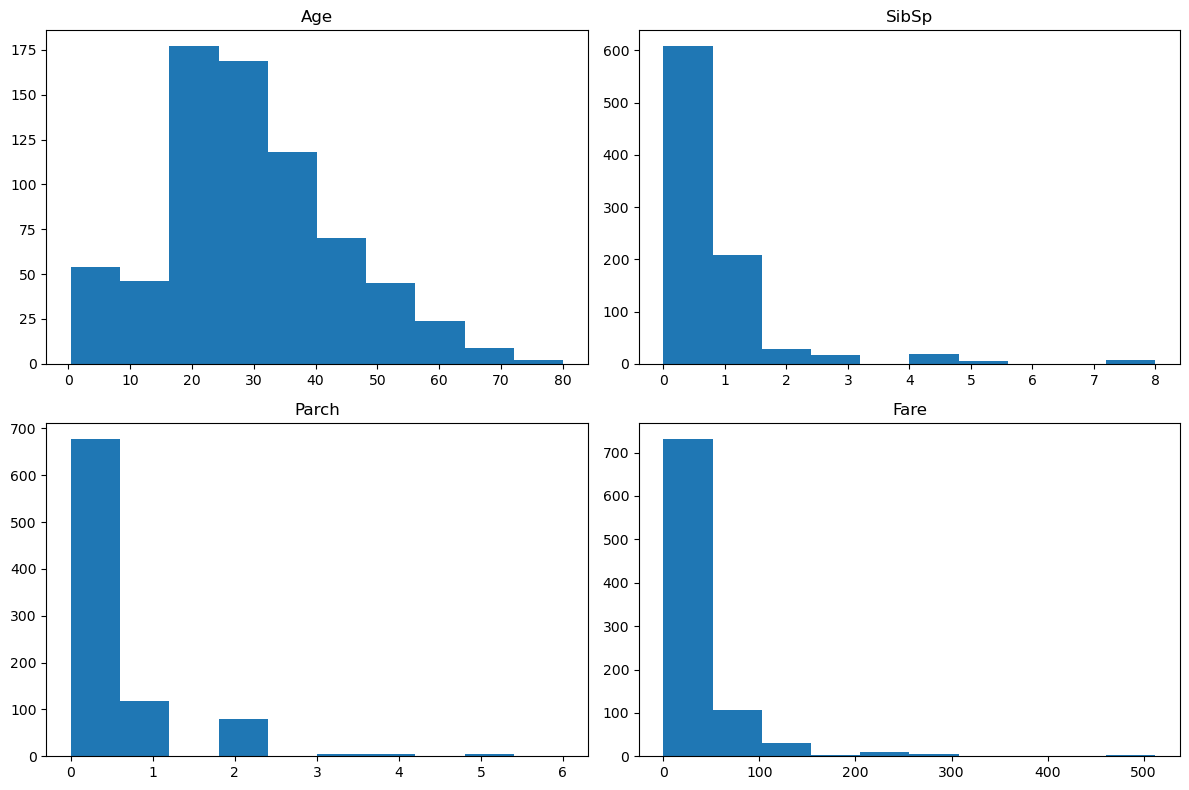

In [9]:
# Creating a grid of subplots for the numeric columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()  # Flatten 2D array to 1D

# Plot each histogram in a subplot
for i, col in enumerate(df_numeric.columns):
    plt.sca(axes[i])
    plt.hist(df_numeric[col])
    plt.title(col)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

We have a normal distribution for the age column. The rest are all good candidates for normalization since they are skewed quite heavily.

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


<Axes: >

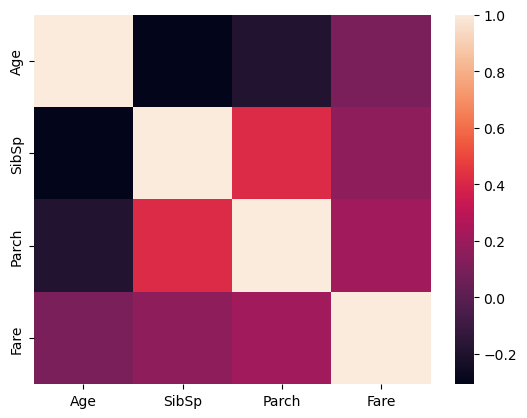

In [10]:
# A look at the correlation of our numeric columns
print(df_numeric.corr())
sns.heatmap(df_numeric.corr())

Here we can see that Parch and SibSp has a higher correlation, which generally makes sense since Parents are more likely to travel with their multiple kids and spouses tend to travel together.

In [11]:
# A look at survival rate across Age, SibSp, Parch, and Fare 
pd.pivot_table(
    data = train,
    values = ['Age', 'SibSp', 'Parch', 'Fare'],
    index = 'Survived'
)

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


There are a few interesting aspects to this:
- The average age of survivors is 28, so young people tend to have a better chance;-  People who paid higher fare rates were more likely to survive, more than double. This might be the people traveling in first-clas,.tThus the rich survive. Higher class cabins were higher up on the ship;.-Travelling with parents shows a significant correlation. Well done, parents on the Titanic;e- Having siblings looks to not be an advantage;ing

### 1.2 Categorical Features Exploration

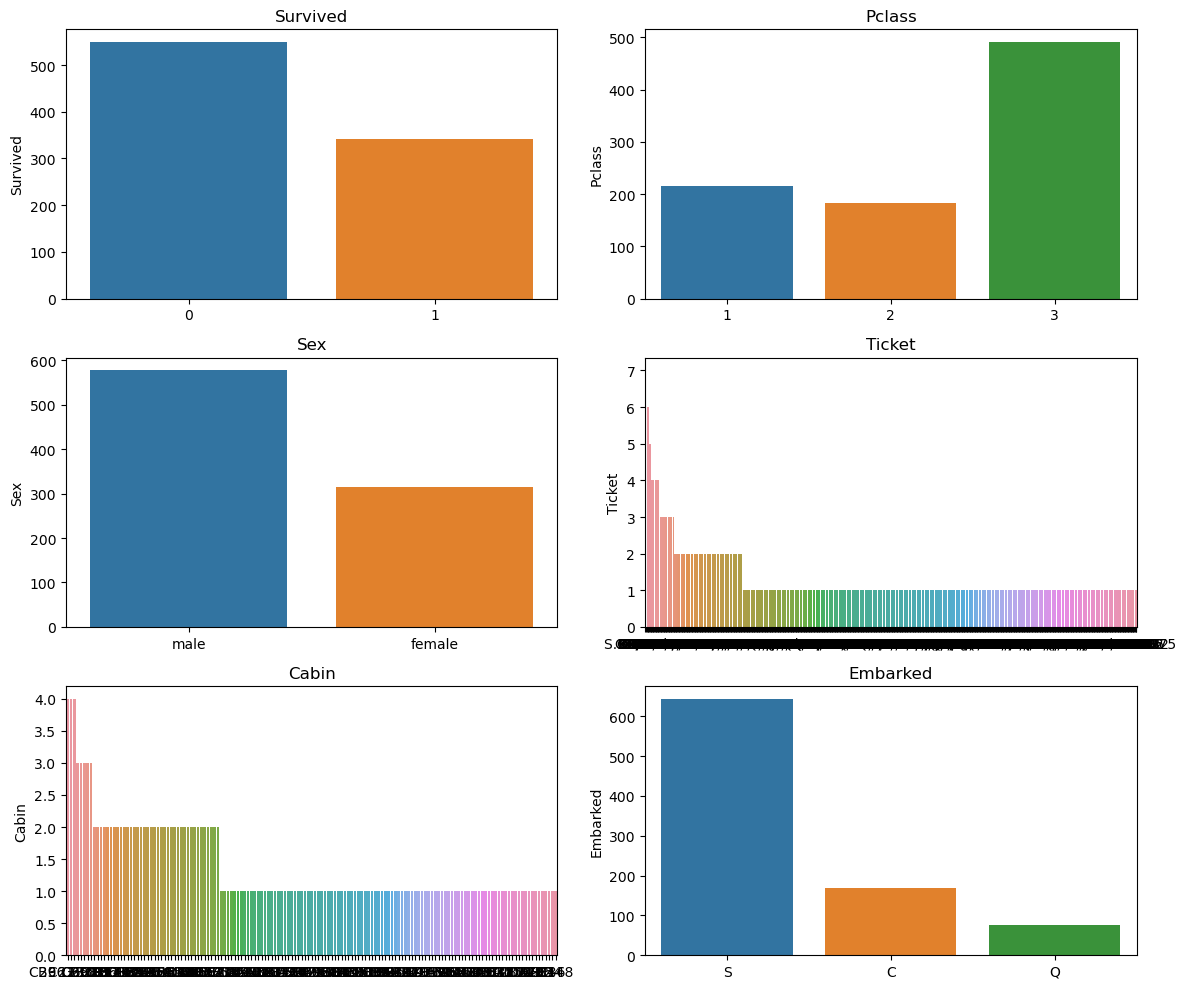

In [12]:
# Same grid of subplots as the one above but containing barplots with our categorical features
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
axes = axes.flatten()

# Plot each barplot in a subplot
for i, col in enumerate(df_categorical.columns):
    sns.barplot(x=df_categorical[col].value_counts().index, y=df_categorical[col].value_counts(), ax=axes[i])
    axes[i].set_title(col)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

- Cabin and ticket graphs are very messy and will need to be addressed (feature engineering);
- Survived: Most of the people died in the shipwreck, only around 300 people survived. The classes are not balanced which needs to be taken into account;
- Pclass: The majority of the people traveling were in 3rd class;
- Sex: There were roughly double the number of men on board than women;
- Embarked: Most of the passengers boarded the ship from Southampton;

In [13]:
# Survival by Pcalss
pd.pivot_table(
    train, 
    index='Survived', 
    columns='Pclass', 
    values='Ticket', 
    aggfunc='count'
)

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


A lot more people survived from the First class than the Second or Third, even though passengers in First class was much much fewer.

In [14]:
# Survival by Sex
pd.pivot_table(
    train, 
    index='Survived', 
    columns='Sex', 
    values='Ticket', 
    aggfunc='count'
)

Sex,female,male
Survived,,
0,81,468
1,233,109


Much better survival rate for women - “Woman and children first”

In [15]:
# Survival by embarked
pd.pivot_table(
    train, 
    index='Survived', 
    columns='Embarked', 
    values='Ticket', 
    aggfunc ='count'
)

Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,217


Embarked seems largely irrelevant. This overview isn't showing much but also just thinking about it intuitively, no reason to think the port from which the person embarked from would have any relevance.

## 2. Feature Engineering
1) Cabin - Simplify cabins (evaluated if cabin letter (cabin_letters) or the purchase of tickets across multiple cabins (cabin_multiple) impacted survival)
2) Tickets - Do different ticket types impact survival rates?
3) Name - Does a person's title relate to survival rates? I am curious if the captain went down with the ship.

### 2.1 Cabin
After looking at this, we may want to look at cabin by letter or by number. Let's create some categories for this:
 - Single letters
 - Multiple letters

In [16]:
train['cabin_multiple'] = train.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
train['cabin_multiple'].value_counts()

0    687
1    180
2     16
3      6
4      2
Name: cabin_multiple, dtype: int64

It looks like the vast majority did not have individual cabins, and only a few people owned more than one.

In [17]:
pd.pivot_table(
    train, 
    index='Survived', 
    columns='cabin_multiple', 
    values='Ticket', 
    aggfunc='count'
)

cabin_multiple,0,1,2,3,4
Survived,,,,,
0,481.0,58.0,7.0,3.0,NaN
1,206.0,122.0,9.0,3.0,2.0


Next, let us look at the actual letter of the cabin they were in. I would expect that the cabins with the same letter are roughly in the same locations, or on the same floors, and logically if a cabin was near the lifeboats, they had a better chance of survival.

In [18]:
# Creates categories based on the cabin letter (n stands for null). In this case we will treat null values like a separate category.
train['cabin_letters'] = train.Cabin.apply(lambda x: str(x)[0])
print(train.cabin_letters.value_counts())

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: cabin_letters, dtype: int64


In [19]:
# Comparing surivial rate by cabin
pd.pivot_table(
    train, 
    index='Survived', 
    columns='cabin_letters', 
    values='Name', 
    aggfunc='count'
)

cabin_letters,A,B,C,D,E,F,G,T,n
Survived,,,,,,,,,
0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0,481.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,206.0


On first glance it does not seem all that relevant.

### 2.2 Ticket

Judging by the initial overview and the description of the feature on Kaggle, this feature is likely not going to provide information that is of much use but let's try and have a more detailed look. Let's begin by having a look at the numeric and non-numeric ticket count:

In [20]:
train['numeric_ticket'] = train.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
train['numeric_ticket'].value_counts()

1    661
0    230
Name: numeric_ticket, dtype: int64

Now let's have a look at the letters in the tickets:

In [21]:
train['ticket_letters'] = train.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.', '').replace('/', '').lower() if len(x.split(' ')[:-1]) > 0 else 0)
train['ticket_letters'].value_counts()

0            665
pc            60
ca            41
a5            21
stono2        18
sotonoq       15
scparis       11
wc            10
a4             7
soc            6
fcc            5
c              5
sopp           3
pp             3
wep            3
ppp            2
scah           2
sotono2        2
swpp           2
fc             1
scahbasle      1
as             1
sp             1
sc             1
scow           1
fa             1
sop            1
sca4           1
casoton        1
Name: ticket_letters, dtype: int64

Letters don't see to be of much use for model training. Let's check out the survival rate for numeric vs non-numeric tickets:

In [22]:
pd.pivot_table(
    train, 
    index='Survived',
    columns='numeric_ticket',
    values='Ticket',
    aggfunc='count'
)

numeric_ticket,0,1
Survived,,
0,142,407
1,88,254


In [23]:
# Survival rate across different ticket types 
pd.pivot_table(
    train,
    index='Survived',
    columns='ticket_letters',
    values='Ticket',
    aggfunc='count'
)

ticket_letters,0,a4,a5,as,c,ca,casoton,fa,fc,fcc,...,soc,sop,sopp,sotono2,sotonoq,sp,stono2,swpp,wc,wep
Survived,,,,,,,,,,,,,,,,,,,,,
0,410.0,7.0,19.0,1.0,3.0,27.0,1.0,1.0,1.0,1.0,...,5.0,1.0,3.0,2.0,13.0,1.0,10.0,NaN,9.0,2.0
1,255.0,NaN,2.0,NaN,2.0,14.0,NaN,NaN,NaN,4.0,...,1.0,NaN,NaN,NaN,2.0,NaN,8.0,2.0,1.0,1.0


Ticket does not seem to be all that relevant to the task at hand.

### 2.3 Name
The only aspect of this feature which I am interested in is the title. It will serve a very similar purpose as the Sax feature but might provide some additional detail. Let's pull out the titles as a separate feature (Mr., Ms., Master., etc:)

In [24]:
train['name_title'] = train.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
train['name_title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: name_title, dtype: int64

## 3. Data Preprocessing for Model Training

1) Drop null values from Embarked (only 2)
2) A number of features will not be of any real use and will be removed. PassendegId, Name and Ticket will be removed but I will keep some of the derived features. List of features that will be retained:
    - `Pclass`
    - `Sex`
    - `Age`
    - `SibSp`
    - `Parch`
    - `Embarked`
    - `cabin_multiple`
    - `name_title`
    - `norm_fare`
3) Apply categorical transformation on all of the available data. Usually we would use a transformer, but with this approach we can ensure that our traning and test data have the same colums. We also may be able to infer something about the shape of the test data using this method.
4) Impute data with mean for fare and age (Also experimented with median)
5) Logarithmic normalization of `Fare` give more semblance of a normal distribution
6) Application of StandardScaler for data scaling

### 3.1 Applying Feature Engineering

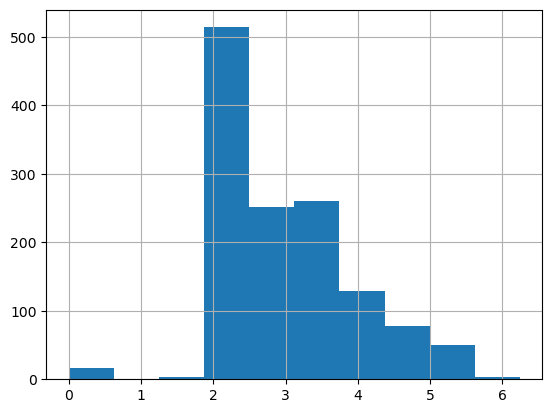

In [25]:
# Setting up all categorical variables that will be used for both the training and the test sets 
all_data['cabin_multiple'] = all_data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['name_title'] = all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

# Engineered categorical features which ended up not being used
# all_data['cabin_letters'] = all_data.Cabin.apply(lambda x: str(x)[0])
# all_data['numeric_ticket'] = all_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
# all_data['ticket_letters'] = all_data.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) > 0 else 0)

# Impute nulls for continuous data 
#all_data.Age = all_data.Age.fillna(training.Age.mean())
all_data.Age = all_data.Age.fillna(train.Age.median())
#all_data.Fare = all_data.Fare.fillna(training.Fare.mean())
all_data.Fare = all_data.Fare.fillna(train.Fare.median())

# Drop null 'Embarked' rows as they are of no relevance (2 instances in the tarining set and none in the testing set)
all_data.dropna(subset=['Embarked'], inplace=True)

# log norm of fare (used)
all_data['norm_fare'] = np.log(all_data.Fare+1)
all_data['norm_fare'].hist()

# Converting fare to a categorical feature for pd.get_dummies()
all_data.Pclass = all_data.Pclass.astype(str)

# Createing dummy variables from categories (also can use OneHotEncoder)
all_dummies = pd.get_dummies(all_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'norm_fare', 'Embarked', 'cabin_multiple', 'name_title', 'train_test']])
# all_dummies = pd.get_dummies(data=all_data, columns=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'norm_fare', 'Embarked', 'cabin_multiple', 'name_title'])

### 3.2 Train/Test split

In [26]:
# I want to make sure that the data remains as a pandas dataframe when splitting. Features get split based on the train_test flag from earlier:
X_train = pd.DataFrame(all_dummies[all_dummies.train_test == 1].drop(['train_test'], axis=1))
X_test = pd.DataFrame(all_dummies[all_dummies.train_test == 0].drop(['train_test'], axis=1))

# Same logic for training labels
y_train = pd.DataFrame(all_data[all_data.train_test == 1].Survived)
y_train = y_train.squeeze()
print('y_train shape ->', y_train.shape)

y_train shape -> (889,)


### 3.3 Scaling

In [27]:
# Now to Scale the data
scale = StandardScaler()
all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age', 'SibSp', 'Parch', 'norm_fare']] = scale.fit_transform(all_dummies_scaled[['Age', 'SibSp', 'Parch', 'norm_fare']])
all_dummies_scaled

X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis = 1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis = 1)

y_train = all_data[all_data.train_test == 1].Survived

### 3.4 Finalized Data Correlations

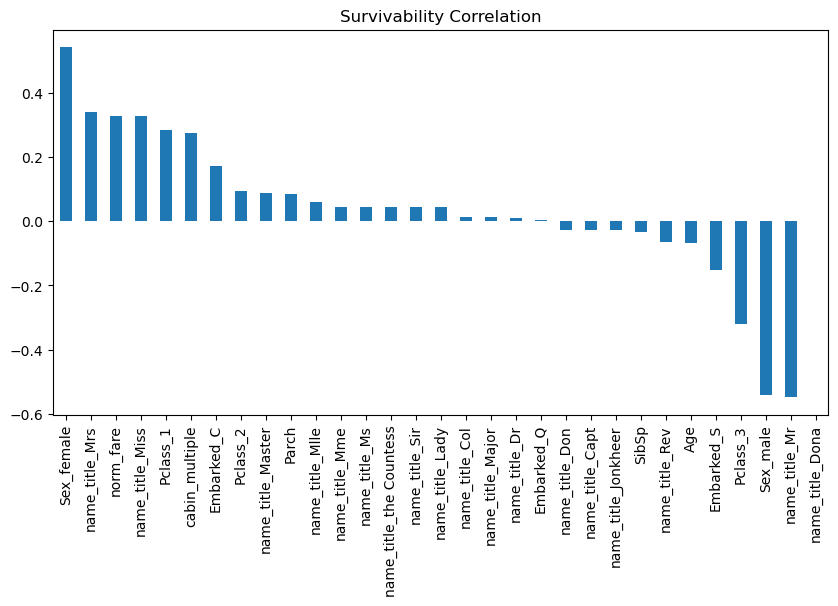

In [28]:
# Concatenate into a full dataset
full_df = pd.concat([X_train, y_train], axis=1)

correlation = full_df.corr()['Survived'].sort_values(ascending=False)

# Correlation graph
correlation[1:].plot(kind='bar', figsize=(10,5), title='Survivability Correlation')
plt.show()

## 4. Metrics and Helper Functions
The metric which the competition is scored on is <b>accuracy</b> so that is what I will stick to as well. I find the <b>F1 score</b> to be more reliable as it is a better descriptior of a model's shortcomings. It also does better with unevenly distributed target calsses as we have in this dataset.

### 4.1 Model Evaluation Functions

In [29]:
# Setting up a constant for the metric input to easily shift between accuracy and F1 score
METRIC = 'accuracy'
# METRIC = 'f1_weighted'

In [30]:
def model_evaluation(models: dict, X_train, y_train):
    """
    This function uses Cross Validation to evaluate models' perfomence. Returns a report of the models' names and mean scores.
    """
    evaluation_report = {}
    for model_name, model in models.items():
        
        if model_name in ['KNeighbors Classifier']:
            X_train = X_train.values  # converting X_train to np.array with .values to avoid warning
            
        cv = cross_val_score(
            model, 
            X_train, 
            y_train, 
            cv=5, 
            scoring=METRIC, 
            n_jobs=-1
        )

        evaluation_report[model_name] = cv.mean()
        
        cv_rounded = [f"{round(score * 100, 1)}%" for score in cv]
        cv_mean = f"{round(cv.mean() * 100, 1)}%"
        
        print(f"{model_name}:\n- CV F1 scores: {' | '.join([item for item in cv_rounded])}\n- CV mean: {cv_mean}\n")

    return evaluation_report

In [31]:
def model_optimisation(models: dict, X_train, y_train, params: dict) -> dict:
    '''
    This function uses dictionaries of models and parameters on which it will run a grid 
    search cross-validation to determine which option is the optimal one for each model.
    Returns a dictionary of models with their best estimators applied.
    '''
    tuned_models = {}
    for model_name, model in models.items():
        
        print(f"{model_name}:")
        
        tuned_model = GridSearchCV(
            model,
            param_grid=params[model_name],
            cv=5,
            scoring=METRIC,
            verbose=True,
            n_jobs=-1
        )
        
        tuned_model.fit(X_train, y_train)
        tuned_models[model_name] = [tuned_model.best_estimator_, tuned_model.best_score_]

        # Report model scores and best parameters
        print('- Best Grid Search F1 Score: ' + str(round(tuned_model.best_score_ * 100, 1)) + '%')
        print('- Best Parameters: ' + str(tuned_model.best_params_))
        print()
        
    return tuned_models

### 4.2 Metric Functions

In [32]:
def generate_classification_report(y_train, y_train_preds, y_test=None, y_test_preds=None):
    """
    The function prints a classification report for the train data and test data if available.
    """
    print(),
    print("--------------------  Train set scores  --------------------"),
    print(classification_report(y_train, y_train_preds))
    
    if y_test is not None and y_test_preds is not None:
        print(),
        print("--------------------  Test set scores  --------------------"),
        print(classification_report(y_test, y_test_preds))

### 4.3 Helper Functions
This section is also where I have stored all functions with miscellaneous uses that will be used throughout the rest of this notebook.

In [33]:
def generate_submissions_csv(predictions, file_name):
    '''
    A function that export predictions to a CSV file in a format compatible with the Kaggle requirements
    '''
    # Create submissions dictionary in the format defined by Kaggle
    submissions_dict = {'PassengerId': test.PassengerId, 'Survived': predictions}
    submissions_df = pd.DataFrame(data=submissions_dict)

    # Setup export folder
    base_path = 'submissions'
    os.makedirs(base_path, exist_ok=True)

    # Generate CSV
    file_path = os.path.join(base_path, file_name)
    submissions_df.to_csv(file_path, index=False)

    print(f'File "{file_name}" saved to <./{base_path}>')

In [34]:
def save_model(model, file_name):
    """
    Save .pkl file
    """
    dir = 'models'
    path = os.path.join(dir, file_name)
    os.makedirs(dir, exist_ok=True)

    with open(path, "wb") as file_obj:
        pickle.dump(model, file_obj)
        
    print(f'File "{file_name}" saved to <./{dir}>')


def load_model(file_name):
    """
    Load .pkl file
    """
    dir = 'models'
    path = os.path.join(dir, file_name)
    with open(path, 'rb') as file:
        model = pickle.load(file)
        
    print(f'File "{file_name}" loaded')
    
    return model

## 5. Model Selection and Baseline Evaluation
To start with I would like to see how various different models perform with default parameters. I tried the models in the below list using 5 fold cross validation to get a baseline. I can later compare these results to the tuned version of these models and see how much tuning improves the performance of each. I can get away with using large number of models for this project since the dataset is not large at all and fitting all these models should only take a few seconds each.

In [35]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state=1),
    'Random Forest Classifier': RandomForestClassifier(random_state=1),
    'GaussianNB': GaussianNB(),
    'KNeighbors Classifier': KNeighborsClassifier(),
    'SVC': SVC(probability=True),
    'XGB Classifier': XGBClassifier(random_state=1),
    'CatBoost Classifier': CatBoostClassifier(silent=True)
}

### 5.1 Scaled vs non-scaled data testing
I want to check what difference scaling the data will have on the scores.

In [36]:
_ = model_evaluation(models, X_train, y_train)

Logistic Regression:
- CV F1 scores: 83.1% | 81.5% | 80.3% | 81.5% | 85.3%
- CV mean: 82.3%

Decision Tree Classifier:
- CV F1 scores: 75.3% | 77.0% | 83.1% | 75.3% | 80.2%
- CV mean: 78.2%

Random Forest Classifier:
- CV F1 scores: 80.9% | 79.2% | 86.0% | 75.8% | 83.1%
- CV mean: 81.0%

GaussianNB:
- CV F1 scores: 68.0% | 76.4% | 79.8% | 78.1% | 70.1%
- CV mean: 74.5%

KNeighbors Classifier:
- CV F1 scores: 77.0% | 79.2% | 80.3% | 80.3% | 83.6%
- CV mean: 80.1%

SVC:
- CV F1 scores: 68.5% | 75.8% | 70.8% | 71.9% | 74.6%
- CV mean: 72.3%

XGB Classifier:
- CV F1 scores: 83.1% | 81.5% | 86.0% | 79.8% | 82.5%
- CV mean: 82.6%

CatBoost Classifier:
- CV F1 scores: 83.7% | 80.3% | 83.7% | 82.0% | 84.2%
- CV mean: 82.8%



In [37]:
_ = model_evaluation(models, X_train_scaled, y_train)

Logistic Regression:
- CV F1 scores: 83.1% | 81.5% | 80.3% | 81.5% | 85.3%
- CV mean: 82.3%

Decision Tree Classifier:
- CV F1 scores: 76.4% | 77.0% | 83.1% | 75.3% | 80.2%
- CV mean: 78.4%

Random Forest Classifier:
- CV F1 scores: 80.3% | 79.2% | 86.0% | 75.3% | 83.1%
- CV mean: 80.8%

GaussianNB:
- CV F1 scores: 62.4% | 65.7% | 79.8% | 78.1% | 62.7%
- CV mean: 69.7%

KNeighbors Classifier:
- CV F1 scores: 81.5% | 79.2% | 84.8% | 82.0% | 84.2%
- CV mean: 82.3%

SVC:
- CV F1 scores: 84.8% | 82.6% | 82.0% | 80.9% | 86.4%
- CV mean: 83.4%

XGB Classifier:
- CV F1 scores: 83.1% | 81.5% | 86.0% | 79.8% | 82.5%
- CV mean: 82.6%

CatBoost Classifier:
- CV F1 scores: 83.7% | 80.3% | 83.7% | 82.0% | 84.2%
- CV mean: 82.8%



Some models are unaffected by the scaling and the rest got improved scores. GaussianNB is the only exception since it's score reduced. That model's overall performance is significantly lower than the rest so it will be getting dropped from the list.

### 5.2 Voting classifier 

The VotingClassifier in scikit-learn combines the predictions from multiple individual classifiers to make a final prediction. There are two main types of voting strategies:

- Hard Voting Classifier - In the hard voting scheme, each classifier in the ensemble casts a single "vote" for a particular class ("yes" or "no"). The final prediction is determined by a majority vote. To ensure a decisive outcome, it's recommended to use an odd number of classifiers.

- Soft Voting Classifier - The soft voting scheme considers the confidence or probability assigned by each classifier for each class. Instead of a simple majority vote, it takes the average of the predicted probabilities. If the average confidence for a particular class surpasses 50%, that class is chosen as the final prediction.

The choice between hard and soft voting often depends on the characteristics of the individual classifiers in the ensemble. Hard voting is suitable when classifiers are diverse and have varying strengths, while soft voting is effective when classifiers provide probability estimates, allowing for a more nuanced decision-making process.

The model will require tuples of model name and model object which I can generate using the models dictionary.

In [38]:
# Build model
voting_clf_model_tuples = [(model_name, model) for model_name, model in models.items()]
voting_clf = VotingClassifier(estimators=voting_clf_model_tuples, voting='soft')

In [39]:
# Evaluate model
_ = model_evaluation({'Voting Classifier': voting_clf}, X_train_scaled.values, y_train)

Voting Classifier:
- CV F1 scores: 82.0% | 82.6% | 84.8% | 80.9% | 87.6%
- CV mean: 83.6%



### 5.3 Voting Classifier Predictions
This model is performing better than the rest so let's generate a submissions file to use as a baseline

In [40]:
# Let's produce a file with preditions to use as a baseline
voting_clf.fit(X_train_scaled.values, y_train)
voting_clf_preds = voting_clf.predict(X_test_scaled.values).astype(int)

# Generate file
generate_submissions_csv(voting_clf_preds, '01_voting_clf_submission.csv')

File "01_voting_clf_submission.csv" saved to <./submissions>


Let's set up a function to use for generating submission files

### 5.4 Model List Cleanup
Let's eliminate some of the models that are not performing that well:
- GaussianNB - poor performance
- Decision Tree Classifier - poor performance and forest should be better in most situations
- SVC - this model has been performing well but it's causing trouble when tuning hyperparameters

In [41]:
models_to_remove = ['GaussianNB', 'Decision Tree Classifier']
for model in models_to_remove:
    if model in models:
        del models[model]

## 6. Hyperparameter Tuning

After getting the baselines, let's see if we can improve on the indivdual model results! I mainly used grid search to tune the models. I also used Randomized Search for the Random Forest and XG boosted model to simplify testing time. Let's build a dictionary of hyperparameter grids for each model. It will be used to tune each model in order to squeeze out every bit of performance. 

| Model                        | Baseline | Tuned Performance |
|------------------------------|----------|-------------------|
| Naive Bayes                  | 72.6%    | NA                |
| Logistic Regression          | 82.1%    | 82.6%             |
| Decision Tree                | 77.6%    | NA                |
| K Nearest Neighbor           | 80.5%    | 83.0%             |
| Random Forest                | 80.6%    | 83.6%             |
| Support Vector Classifier    | 83.2%    | 83.2%             |
| Xtreme Gradient Boosting     | 81.8%    | 85.3%             |

Some grids have been reduced in size after initial searches to cut on time spent on subsequent runs.

In [42]:
model_params = {
    'Logistic Regression': {
        'max_iter' : [10, 50, 100, 1000],
        'penalty' : ['l1', 'l2'],
        'C' : np.logspace(-4, 4, 20),
        'solver' : ['liblinear']
        },
    # 'Random Forest Classifier': {
    #     'n_estimators': [100, 500, 1000], 
    #     'bootstrap': [True, False],
    #     'max_depth': [3, 5, 10, 20, 50, 75, 100, None],
    #     'max_features': ['auto', 'sqrt', 'log2'],
    #     'min_samples_leaf': [1, 2, 4, 10],
    #     'min_samples_split': [2, 5, 10]
    #     },
    'Random Forest Classifier': {
        'n_estimators': [100, 300, 450],
        'criterion':['gini', 'entropy'], 
        'bootstrap': [True],
        'max_depth': [10, 15],
        'max_features': ['sqrt', 20, 40],
        'min_samples_leaf': [1, 2],
        'min_samples_split': [.5, 2]
        },
    'KNeighbors Classifier': {
        'n_neighbors' : [3, 5, 7, 9, 12, 15],
        'weights' : ['uniform', 'distance'],
        'algorithm' : ['ball_tree', 'kd_tree'],
        'p' : [1, 2]
        },
    'SVC': [
        {'kernel': ['rbf'], 'gamma': [.1, .5, 1, 2, 5, 10], 'C': [.1, 1, 10]},
        {'kernel': ['linear'], 'C': [.1, 1, 10]},
        {'kernel': ['poly', 'linear', 'rbf'], 'degree' : [1, 2, 3], 'C': [.1, 1, 10]}
        ],
    'XGB Classifier': {
        'n_estimators': [500, 550],
        'colsample_bytree': [.5, .6, .75],
        'max_depth': [10, None],
        'reg_alpha': [1],
        'reg_lambda': [5, 10, 15],
        'subsample': [.55, .6, .65],
        'learning_rate':[.5],
        'gamma':[.25, .5, 1],
        'min_child_weight':[0.01],
        'sampling_method': ['uniform']
        },
    'CatBoost Classifier': {
        'iterations': [400, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [2, 4, 6],
        'l2_leaf_reg': [1, 2],
        'border_count': [64, 128]
    }
}

Let's now run the hyperparameter grid search and save the results for each model along with the model's best performing version in a dictionary which will allow for easy access to everything I might need in regards to these models later on.

In [43]:
# Let's see if we can get some increase in performance
tuned_models = model_optimisation(models, X_train_scaled, y_train, model_params)

Logistic Regression:
Fitting 5 folds for each of 160 candidates, totalling 800 fits
- Best Grid Search F1 Score: 82.6%
- Best Parameters: {'C': 1.623776739188721, 'max_iter': 50, 'penalty': 'l1', 'solver': 'liblinear'}

Random Forest Classifier:
Fitting 5 folds for each of 144 candidates, totalling 720 fits
- Best Grid Search F1 Score: 84.4%
- Best Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

KNeighbors Classifier:
Fitting 5 folds for each of 48 candidates, totalling 240 fits
- Best Grid Search F1 Score: 82.8%
- Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 12, 'p': 1, 'weights': 'uniform'}

SVC:
Fitting 5 folds for each of 48 candidates, totalling 240 fits
- Best Grid Search F1 Score: 83.4%
- Best Parameters: {'C': 1, 'degree': 2, 'kernel': 'poly'}

XGB Classifier:
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
- Best Grid Search F1 Score: 

Unsurprisingle, age and sex are big determinants of the outcome. It's quite interesting that the normalized Fare is the feature with the greatest importance.

### 6.1 Tuned XGB Predictions
XGB Classifier is the best performing model so far so let's generate a submissions file using this tuned version

In [44]:
xgb_predictions = tuned_models['XGB Classifier'][0].predict(X_test_scaled).astype(int)
generate_submissions_csv(xgb_predictions, '02_xgb_tuned_submission.csv')

File "02_xgb_tuned_submission.csv" saved to <./submissions>


### 6.2 Feature Importances
I am quite interested in the feature importances so let's have a look.

<Axes: >

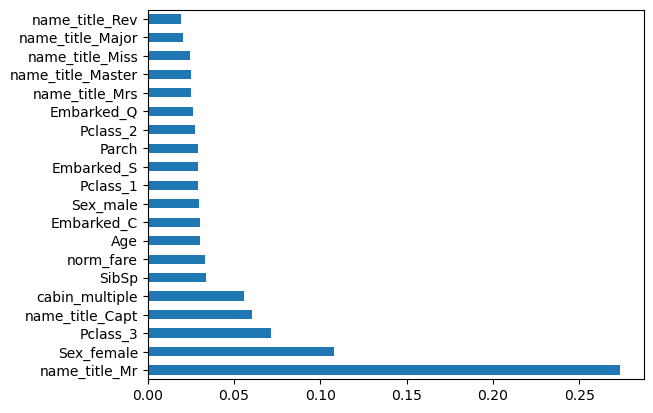

In [45]:
best_xgb = tuned_models['XGB Classifier'][0].fit(X_train_scaled, y_train)
feat_importances = pd.Series(best_xgb.feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh')

<Axes: >

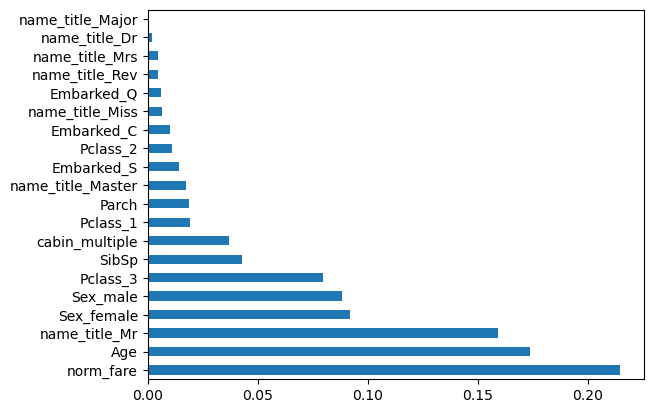

In [46]:
best_rf = tuned_models['Random Forest Classifier'][0].fit(X_train_scaled, y_train)
feat_importances = pd.Series(best_rf.feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh')

## 7. Additional Ensemble Approaches using Voting Classifier
1) Experimented with a <b>Hard Voting</b> classifier

2) Experimented with a <b>Soft Voting</b> classifier

3) Experimented with <b>Soft Voting while eliminating worst performing model</b>

4) Experimented with <b>Soft Voting while eliminating the two worst performing</b>

Let's run a voting classifier using the tuned models. I also want to try and eliminate some of the models to see if that improves performance.

In [47]:
tuned_model_tuples = [(model_name, model[0]) for model_name, model in tuned_models.items()]
voting_clf_all = VotingClassifier(estimators=tuned_model_tuples, voting='hard')
_ = model_evaluation({'Voting Classifier': voting_clf_all}, X_train_scaled, y_train)

Voting Classifier:
- CV F1 scores: 86.0% | 83.7% | 86.5% | 80.3% | 87.0%
- CV mean: 84.7%



In [48]:
tuned_model_tuples = [(model_name, model[0]) for model_name, model in tuned_models.items()]
voting_clf_all = VotingClassifier(estimators=tuned_model_tuples, voting='soft')
_ = model_evaluation({'Voting Classifier': voting_clf_all}, X_train_scaled, y_train)

Voting Classifier:
- CV F1 scores: 84.3% | 84.3% | 84.3% | 80.3% | 85.9%
- CV mean: 83.8%



In [49]:
tuned_model_tuples = [(model_name, model[0]) for model_name, model in tuned_models.items() if model_name not in ['Logistic Regression']]
voting_clf_all = VotingClassifier(estimators=tuned_model_tuples, voting='soft')
_ = model_evaluation({'Voting Classifier': voting_clf_all}, X_train_scaled, y_train)

Voting Classifier:
- CV F1 scores: 85.4% | 84.3% | 85.4% | 80.9% | 86.4%
- CV mean: 84.5%



In [50]:
tuned_model_tuples = [(model_name, model[0]) for model_name, model in tuned_models.items() if model_name not in ['Logistic Regression', 'KNeighbors Classifier']]
voting_clf_all = VotingClassifier(estimators=tuned_model_tuples, voting='soft')
_ = model_evaluation({'Voting Classifier': voting_clf_all}, X_train_scaled, y_train)

Voting Classifier:
- CV F1 scores: 84.8% | 83.7% | 86.0% | 80.9% | 86.4%
- CV mean: 84.4%



Hard voting seems to be the way to go. Also, removing the worst performing models does produce an improved score as well so let's keep that approach.

### 7.1 Voting Classifier Optimisation
In a soft voting classifier you can apply weights to each of the models. Let's use a grid search to explore different weightings. 

To not have to adjust the grid every time the models count change we generate a grid using itertools.

In [51]:
# Weights grid
combinations = itertools.product([1, 2], repeat=len(tuned_model_tuples))  # Generate all possible combinations of weights
combinations = [list(comb) for comb in combinations if len(set(comb)) != 1]  # Filter out the combinations where all elements are the same

# Voting classifier param grid
voting_classifier_params = {'Voting Classifier': {'weights': combinations, 'voting': ['soft', 'hard']}}

# Optimising the voting classifier
tuned_voting_clf = model_optimisation(
    {'Voting Classifier': voting_clf_all},
    X_train_scaled,
    y_train,
    voting_classifier_params
)

Voting Classifier:
Fitting 5 folds for each of 28 candidates, totalling 140 fits
- Best Grid Search F1 Score: 85.5%
- Best Parameters: {'voting': 'hard', 'weights': [1, 1, 2, 1]}



The performence does improve after tuning but not by that much. Let's add this tuned Voting Classifier to the dictionary of models which can then be sorted which will allow the best performing model to be easily retrieved.

In [52]:
# Adding the Voting Classifier to the tuned models dictionary and sorting it to easily retrieve the best performing model
tuned_models = {**tuned_voting_clf, **tuned_models}
sorted_tuned_models = dict(sorted(tuned_models.items(), key=lambda item: -item[1][1]))

## 8. Final Submissions
Let's take the best performing model from our tuned_models dict and use it to generate the final submission file. I'll also save that model for later use.

In [53]:
# Taking best model from dictionary
best_model_name, best_model_tuple = list(sorted_tuned_models.items())[0]
best_model, best_model_score = best_model_tuple
print(f"Best performing model -> {best_model_name} with anm F1 score of {round(best_model_score * 100, 1)}%")

Best performing model -> XGB Classifier with anm F1 score of 85.7%


In [54]:
# Generating final submission file
best_model_preds = best_model.predict(X_test_scaled).astype(int)
generate_submissions_csv(xgb_predictions, '03_optimised_model_submission.csv')

# Saving model
save_model(best_model, 'titanic_survival_classifier.pkl')

File "03_optimised_model_submission.csv" saved to <./submissions>
File "titanic_survival_classifier.pkl" saved to <./models>
